# Function Calling with Ollama, Llama 3.1 and Milvus

Function calling with LLMs is like giving your AI the power to connect with the world. By integrating your LLM with external tools such as user-defined functions or APIs, you can build applications that solve real-world problems.

# Milvus Lite 

Milvus Lite is the lightweight version of Milvus, a high-performance vector database that powers AI applications with vector similarity search.

Milvus Lite shares the same API with Milvus Standalone and Distributed, and covers most of the features such as vector data persistence and management, vector CRUD operations, sparse and dense vector search, metadata filtering, multi-vector and hybrid_search.

# Ollama

Run different LLMs on your laptop, simplifying local operation.

### Check out Github on: https://github.com/milvus-io/milvus

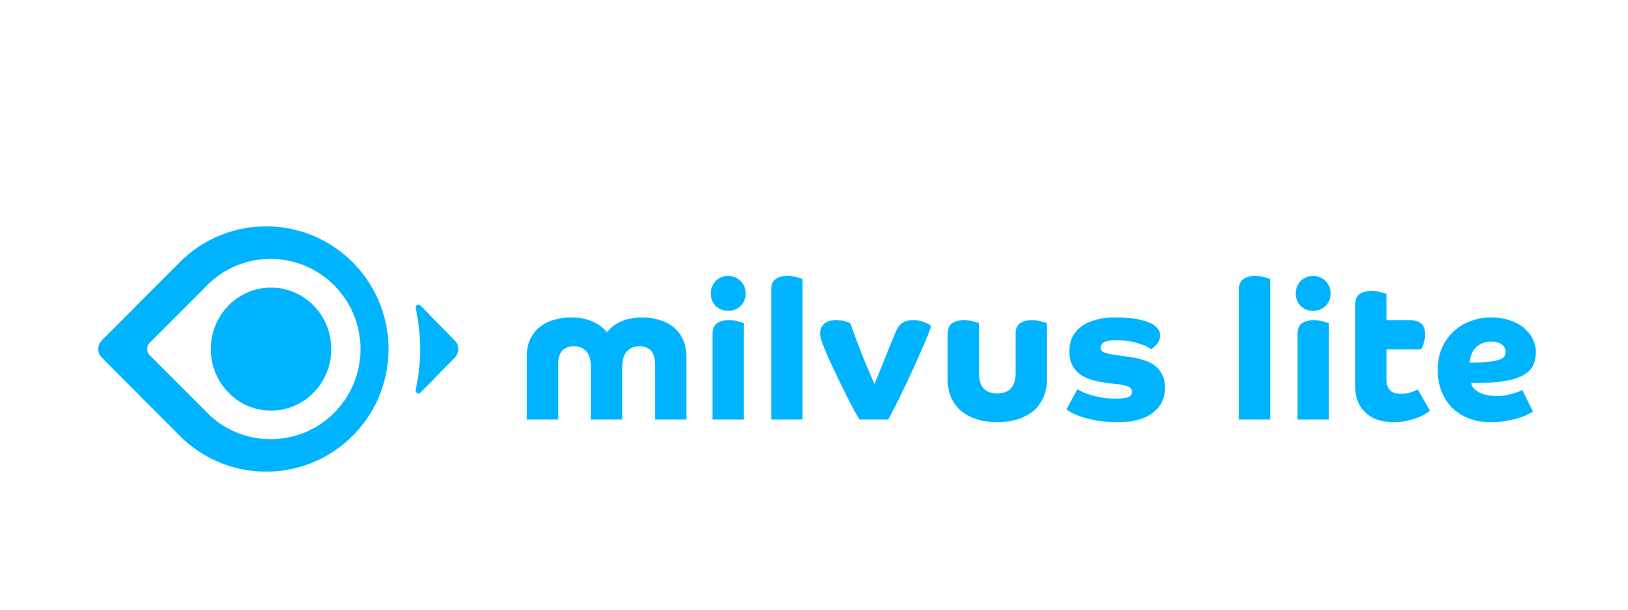

# Download Llama3.1 with Ollama 

Run in your terminal: `ollama run llama3.1`

In [ ]:
! pip install -U ollama openai "pymilvus[model]"

# Create Embeddings

Milvus, with the `model` subpackage, supports the generation of Embeddings. By integrating mainstream embedding models, you can easily transform original text into searchable vectors or rerank the results using powerful models to achieve more accurate results for RAG.

In [19]:
import random
from pymilvus import model

docs = [
    "Artificial intelligence was founded as an academic discipline in 1956.",
    "Alan Turing was the first person to conduct substantial research in AI.",
    "Born in Maida Vale, London, Turing was raised in southern England.",
]

embedding_fn = model.DefaultEmbeddingFunction() # all-MiniLM-L6-v2 by default

vectors = embedding_fn.encode_documents(docs)

# The output vector has 768 dimensions, matching the collection that we just created.
print("Dim:", embedding_fn.dim, vectors[0].shape)  # Dim: 768 (768,)

# Each entity has id, vector representation, raw text, and a subject label that we use
# to demo metadata filtering later.
data = [
    {"id": i, "vector": vectors[i], "text": docs[i], "subject": "history"}
    for i in range(len(vectors))
]

print("Data has", len(data), "entities, each with fields: ", data[0].keys())
print("Vector dim:", len(data[0]["vector"]))


Dim: 768 (768,)
Data has 3 entities, each with fields:  dict_keys(['id', 'vector', 'text', 'subject'])
Vector dim: 768


# Insert the data in Milvus

Our data has been transformed into vectors now, we can insert it into Milvus. By doing so, we can then have access to it, search it and this is what our Agent will do. 

In [20]:
from pymilvus import MilvusClient

client = MilvusClient('./milvus_local.db')

if client.has_collection('demo_collection'):
    client.drop_collection('demo_collection')
    
client.create_collection(
    collection_name="demo_collection",
    dimension=768,  # The vectors we will use in this demo has 768 dimensions
)

client.insert(collection_name="demo_collection", data=data)


{'insert_count': 3, 'ids': [0, 1, 2], 'cost': 0}

# Define the functions!

Being able to use tools makes it possible for LLMs to perform more complex tasks and interact with the outside world.

In this tutorial, we're defining two functions. The first one simulates an API call to get flight times. The second one runs a search query in Milvus.

When defining a function that can be called by an LLM, the description of the function matters significantely, it can help with: 
* **Understanding Functionality** - The description explains what the function does, the parameters it expects, and the type of output it returns. 
* **Matching Intent** - When a user makes a request, the LLM uses the function descriptions to match the user's intent with the appropriate function.
* **Parameter Handling** -  This helps the LLM extract the necessary information from the user's input to correctly call the function.

In [21]:
import json
import ollama

# Simulates an API call to get flight times
# In a real application, this would fetch data from a live database or API
def get_flight_times(departure: str, arrival: str) -> str:
    flights = {
        'NYC-LAX': {'departure': '08:00 AM', 'arrival': '11:30 AM', 'duration': '5h 30m'},
        'LAX-NYC': {'departure': '02:00 PM', 'arrival': '10:30 PM', 'duration': '5h 30m'},
        'LHR-JFK': {'departure': '10:00 AM', 'arrival': '01:00 PM', 'duration': '8h 00m'},
        'JFK-LHR': {'departure': '09:00 PM', 'arrival': '09:00 AM', 'duration': '7h 00m'},
        'CDG-DXB': {'departure': '11:00 AM', 'arrival': '08:00 PM', 'duration': '6h 00m'},
        'DXB-CDG': {'departure': '03:00 AM', 'arrival': '07:30 AM', 'duration': '7h 30m'},
    }

    key = f'{departure}-{arrival}'.upper()
    return json.dumps(flights.get(key, {'error': 'Flight not found'}))

# Search data related to Artificial Intelligence in a vector database
def search_data_in_vector_db(query: str) -> str:
    query_vectors = embedding_fn.encode_queries([query])

    res = client.search(
        collection_name="demo_collection",
        data=query_vectors,
        limit=2,
        output_fields=["text", "subject"],  # specifies fields to be returned
    )
    print(res)
    return json.dumps(res)

In [30]:
def run(model: str, question: str):
    client = ollama.Client()
    # Initialize conversation with a user query
    messages = [{'role': 'user', 'content': question}]

    # First API call: Send the query and function description to the model
    response = client.chat(
        model=model,
        messages=messages,
        tools=[
            {
                'type': 'function',
                'function': {
                    'name': 'get_flight_times',
                    'description': 'Get the flight times between two cities',
                    'parameters': {
                        'type': 'object',
                        'properties': {
                            'departure': {
                                'type': 'string',
                                'description': 'The departure city (airport code)',
                            },
                            'arrival': {
                                'type': 'string',
                                'description': 'The arrival city (airport code)',
                            },
                        },
                        'required': ['departure', 'arrival'],
                    },
                },
            },
            {
                'type': 'function',
                'function': {
                    'name': 'search_data_in_vector_db',
                    'description': 'Search about Artificial Intelligence data in a vector database',
                    'parameters': {
                        'type': 'object',
                        'properties': {
                            'query': {
                                'type': 'string',
                                'description': 'The search query',
                            },
                        },
                        'required': ['query'],
                    },
                },
            },
        ],
    )

    # Add the model's response to the conversation history
    messages.append(response['message'])

    # Check if the model decided to use the provided function
    if not response['message'].get('tool_calls'):
        print("The model didn't use the function. Its response was:")
        print(response['message']['content'])
        return

    # Process function calls made by the model
    if response['message'].get('tool_calls'):
        available_functions = {
            'get_flight_times': get_flight_times,
            'search_data_in_vector_db': search_data_in_vector_db,
        }
        for tool in response['message']['tool_calls']:
            function_to_call = available_functions[tool['function']['name']]
            function_args = tool['function']['arguments']
            function_response = function_to_call(**function_args)
            # Add function response to the conversation
            messages.append(
                {
                    'role': 'tool',
                    'content': function_response,
                }
            )
            
    print(messages)
    # Second API call: Get final response from the model
    final_response = client.chat(model=model, messages=messages)
    print(final_response['message']['content'])

# Examples

In the examples below, you will see the Agent in action: 
1. Pass the content to the LLM
2. The LLM picks the right function to call
3. Infers the arguments needed to call the function
4. Get the result from the said function
5. Generate some text based on the answer of the tool.

### First example
In the first example, we ask: `What is the flight time from New York (NYC) to Los Angeles (LAX)?`. We can see that we call the function `get_flight_times()`, with the arguments `{'arrival': 'LAX', 'departure': 'NYC'}`. 
We get the `content` as a return `{"departure": "08:00 AM", "arrival": "11:30 AM", "duration": "5h 30m"}`. 

Then, this is given to the LLM, and it can generate the text we have below, saying that it takes approximately 5 hours and 30 minutes.

### Second Example
In the second one, we ask `What is Artificial Intelligence?`. This is stored in Milvus, so the LLM picks the `search_data_in_vector_db` with the query `Artificial Intelligence`, we then get a result from Milvus saying: `Artificial intelligence was founded as an academic discipline in 1956`. 
Finally, we give this result back to our LLM, which then generates quick a long text with the result we just got back.


In [31]:
question = "What is the flight time from New York (NYC) to Los Angeles (LAX)?"
run('llama3.1', question)


[{'role': 'user', 'content': 'What is the flight time from New York (NYC) to Los Angeles (LAX)?'}, {'role': 'assistant', 'content': '', 'tool_calls': [{'function': {'name': 'get_flight_times', 'arguments': {'arrival': 'LAX', 'departure': 'NYC'}}}]}, {'role': 'tool', 'content': '{"departure": "08:00 AM", "arrival": "11:30 AM", "duration": "5h 30m"}'}]
The flight time from New York (NYC) to Los Angeles (LAX) is approximately 5 hours and 30 minutes. However, please note that this can vary depending on several factors such as the airline, flight schedule, and any potential layovers or delays.

In reality, flights from NYC to LAX typically take around 5-6 hours with no stops, but it's always best to check with your airline or a flight search engine for the most up-to-date and accurate information.


In [32]:
question = "What is Artificial Intelligence?"
run('llama3.1', question)

data: ["[{'id': 0, 'distance': 0.4702666699886322, 'entity': {'text': 'Artificial intelligence was founded as an academic discipline in 1956.', 'subject': 'history'}}, {'id': 1, 'distance': 0.2702862620353699, 'entity': {'text': 'Alan Turing was the first person to conduct substantial research in AI.', 'subject': 'history'}}]"] , extra_info: {'cost': 0}
[{'role': 'user', 'content': 'What is Artificial Intelligence?'}, {'role': 'assistant', 'content': '', 'tool_calls': [{'function': {'name': 'search_data_in_vector_db', 'arguments': {'query': 'Artificial Intelligence'}}}]}, {'role': 'tool', 'content': '[[{"id": 0, "distance": 0.4702666699886322, "entity": {"text": "Artificial intelligence was founded as an academic discipline in 1956.", "subject": "history"}}, {"id": 1, "distance": 0.2702862620353699, "entity": {"text": "Alan Turing was the first person to conduct substantial research in AI.", "subject": "history"}}]]'}]
Artificial Intelligence (AI) refers to the development of computer 

# ⭐️ Github

We hope you liked this tutorial showcasing how to use Function Calling using Ollama, Llama 3.1 and Milvus. 

If you liked it and our project, please **give us a star on [Github](https://github.com/milvus-io/milvus)!** ⭐

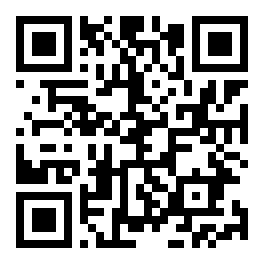

# 🤝 Add me on Linkedin!
If you have some questions related to Milvus, GenAI, etc, I am Stephen Batifol, you can add me on [LinkedIn](https://www.linkedin.com/in/stephen-batifol/) and I'll gladly help you. 

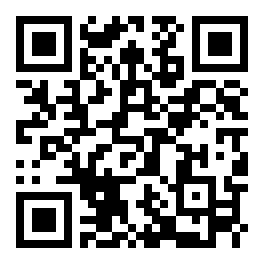



